# Visualizing COVID-19 data using Matplotlib and GeoPandas

Analysts all over the world have collected data on the COVID-19 pandemic, from reported cases to government responses. In this notebook, we'll try to visualize some of this data in interesting ways. Let's start by downloading the packages we'll need. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import colors
from matplotlib.colors import rgb2hex
from PIL import Image

We'll use data collected by the University of Oxford (https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker). The dataframe <code>data</code> stores information on new cases, new deaths, total cases, and total deaths, whereas the dataframe <code>responses</code> dataframe documents government responses. Let's restrict our attention to the United States for now.

In [2]:
data = pd.read_csv("./Downloads/full_data.csv")
responses = pd.read_csv("./Downloads/responses.csv")
responses["Date"] = pd.to_datetime(responses["Date"], format = "%Y%m%d")
data["date"] = pd.to_datetime(data["date"], format = "%Y-%m-%d")
usa_data = data[data["location"] == "United States"]
usa_responses = responses[responses["CountryName"] == "United States"]
usa_data.sample(5)

,date,location,new_cases,new_deaths,total_cases,total_deaths
22572,2020-01-15,United States,0,0,0,0
22615,2020-02-27,United States,6,0,59,0
22622,2020-03-05,United States,34,2,159,11
22683,2020-05-05,United States,22593,1252,1180634,68934
22666,2020-04-18,United States,30833,3770,702164,37054


We'll track shelter-in-place, travel, public gathering, and testing regulations. 

In [3]:
restrictions = usa_responses[["Date", "C6_Stay at home requirements", "C8_International travel controls", "C4_Restrictions on gatherings", "H2_Testing policy"]]
sip = restrictions[restrictions["C6_Stay at home requirements"] >= 2].iloc[0, 0]
tc = restrictions[restrictions["C8_International travel controls"] > 0].iloc[0, 0]
pg = restrictions[restrictions["C4_Restrictions on gatherings"] > 0].iloc[0, 0]
testing = restrictions[restrictions["H2_Testing policy"] > 2].iloc[0, 0]
print("shelter-in-place: ", sip)
print("travel controls: ", tc)
print("public gatherings: ", pg)
print("testing: ", testing)

shelter-in-place:  2020-03-15 00:00:00
travel controls:  2020-02-02 00:00:00
public gatherings:  2020-03-11 00:00:00
testing:  2020-03-14 00:00:00


It's beneficial to know when these restrictions were put in place, but it would be more insightful to show them relative to other data. Let's plot new virus cases in the United States over time.

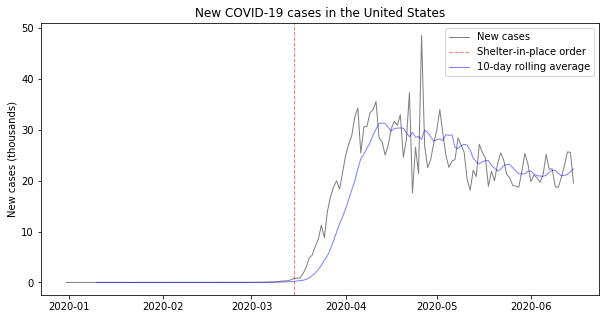

In [4]:
x = usa_data["date"]
y = usa_data["new_cases"]
n = 10
z = np.zeros(len(x) - n)
for i in range(n, len(x)):
    avg = np.mean(y[i - n:i])
    z[i - n] = avg
fig = plt.figure(figsize = (10, 5))
plt.plot(x, y / 1e3, color = "k", alpha = 0.5, lw = 1, label = "New cases")
plt.axvline(x = sip, linestyle = "--", color = "red", alpha = 0.5, lw = 1, label = "Shelter-in-place order")
plt.plot(x[n:], z / 1e3, color = "blue", alpha = 0.5, lw = 1, label = str(n) + "-day rolling average")
plt.ylabel("New cases (thousands)")
plt.legend()
plt.title("New COVID-19 cases in the United States")
plt.show()

The red line shows when the shelter-in-place order was enacted. The number of reported cases surges almost immediately afterwards, suggesting that governmental restrictions were slow. Since the quarantine order went through as the curve was rising, there was likely insufficient time to respond. 

The blue line is a 10-day rolling average of the data. It is promising to see the curve flatten in mid-April and decrease throughout May and June, but the number of new cases is still alarmingly high. Let's try doing a similar analysis on new COVID-19 deaths in the United States.

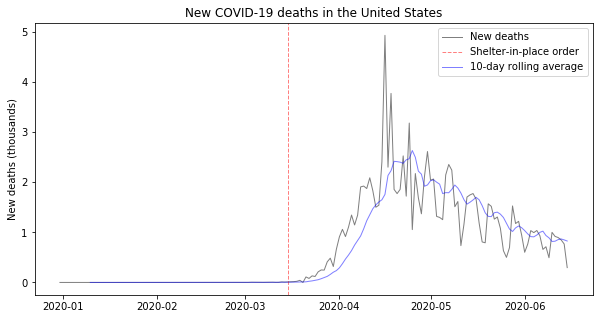

In [5]:
x = usa_data["date"]
y = usa_data["new_deaths"]
n = 10
z = np.zeros(len(x) - n)
for i in range(n, len(x)):
    avg = np.mean(y[i - n:i])
    z[i - n] = avg
fig = plt.figure(figsize = (10, 5))
plt.plot(x, y / 1e3, color = "k", alpha = 0.5, lw = 1, label = "New deaths")
plt.axvline(x = sip, linestyle = "--", color = "red", alpha = 0.5, lw = 1, label = "Shelter-in-place order")
plt.plot(x[n:], z / 1e3, color = "blue", alpha = 0.5, lw = 1, label = str(n) + "-day rolling average")
plt.ylabel("New deaths (thousands)")
plt.legend()
plt.title("New COVID-19 deaths in the United States")
plt.show()

The data shows similar behavior, although the curve seems to be dropping somewhat more quickly. This suggests that symptoms are detected earlier now than they were in April, meaning deaths are more easily prevented. It is interesting to note the sinusoidal pattern in both graphs, probably due to weekly patterns in reports and treatment.

Let's compare the United States to Japan.

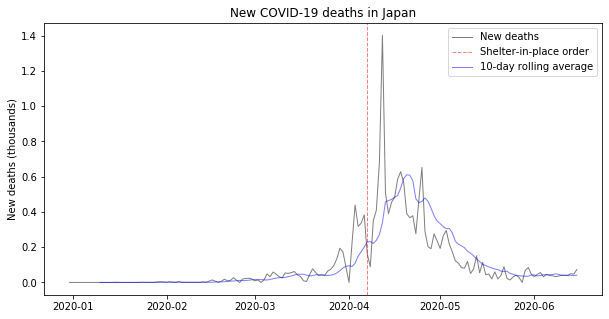

In [6]:
japan_data = data[data["location"] == "Japan"]
japan_responses = responses[responses["CountryName"] == "Japan"]
temp = japan_responses[["Date", "C6_Stay at home requirements"]]
sip = temp[temp["C6_Stay at home requirements"] >= 1].iloc[0, 0]
x = japan_data["date"]
y = japan_data["new_cases"]
n = 10
z = np.zeros(len(x) - n)
for i in range(n, len(x)):
    avg = np.mean(y[i - n:i])
    z[i - n] = avg
fig = plt.figure(figsize = (10, 5))
plt.plot(x, y / 1e3, color = "k", alpha = 0.5, lw = 1, label = "New deaths")
plt.axvline(x = sip, linestyle = "--", color = "red", alpha = 0.5, lw = 1, label = "Shelter-in-place order")
plt.plot(x[n:], z / 1e3, color = "blue", alpha = 0.5, lw = 1, label = str(n) + "-day rolling average")
plt.ylabel("New deaths (thousands)")
plt.legend()
plt.title("New COVID-19 deaths in Japan")
plt.show()

The curve peaks earlier and drops far more quickly. Interestingly enough, the shelter-in-place order is enacted fairly late relative to the start of the pandemic. The differences between the US and Japan may be tied to the efficiency of responses by local governments and citizens. Policy enactment in the US is largely delegated to state governments, which are free to choose different courses of action. The lack of a unified response, insufficient healthcare resources, and public unwillingness to comply with quarantine measures, are perhaps responsible for the slow decline of the curve.

Let's try to make a chloropleth map of the severity of the pandemic worldwide. For this, we'll need the GeoPandas package. We'll import shape files (obtained from http://www.naturalearthdata.com/downloads/10m-cultural-vectors) of all countries into the dataframe <code>gdf</code>. For convenience, we'll rename a few columns of <code>data</code>.

In [7]:
gdf = gpd.read_file("./Downloads/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")[['ADM0_A3', 'geometry']].to_crs('+proj=robin')
data.rename(columns = {'date' : 'Date', 'location' : 'CountryName'}, inplace = True)

First, we'll merge the <code>responses</code> and <code>data</code> dataframes on the keys for country name and date.

In [8]:
deaths = responses.merge(data, on = ["CountryName", "Date"])
deaths = deaths.groupby(["CountryName"]).apply(lambda g : g.iloc[-1, :])[["CountryCode", "total_deaths"]].reset_index()
deaths.sample(5)

,CountryName,CountryCode,total_deaths
75,Iran,IRN,8837
128,Russia,RUS,6948
116,Pakistan,PAK,2729
152,Thailand,THA,58
83,Kazakhstan,KAZ,77


Next we'll merge <code>deaths</code> and <code>gdf</code> using the country codes. To make the data look nicer, we'll switch to a logarithmic scale and normalize the values.

In [9]:
def fun(col):
    return pd.Series([np.log10(x) if x > 0 else 0 for x in col])

In [10]:
merged = gdf.merge(deaths, left_on = 'ADM0_A3', right_on = 'CountryCode')
merged['total_deaths'] = fun(merged['total_deaths'])
merged['total_deaths'] = merged['total_deaths'] * 100 / np.max(merged['total_deaths'])
merged.sample(5)

,ADM0_A3,geometry,CountryName,CountryCode,total_deaths
130,GHA,"POLYGON ((-15605.550 1190907.528, -14906.680 1...",Ghana,GHA,34.213680
119,PRY,"POLYGON ((-5790994.007 -2378022.391, -5789407....",Paraguay,PRY,20.566846
16,TZA,"MULTIPOLYGON (((3097434.715 -1006193.062, 3096...",Tanzania,TZA,26.112994
152,JPN,"MULTIPOLYGON (((11700269.140 3401088.226, 1170...",Japan,JPN,58.579421
13,KEN,"MULTIPOLYGON (((3244261.642 494134.742, 325160...",Kenya,KEN,39.752261


Finally, we'll plot the results using a color map of our choice. We can play around with the colorbar settings to make the result a bit cleaner.

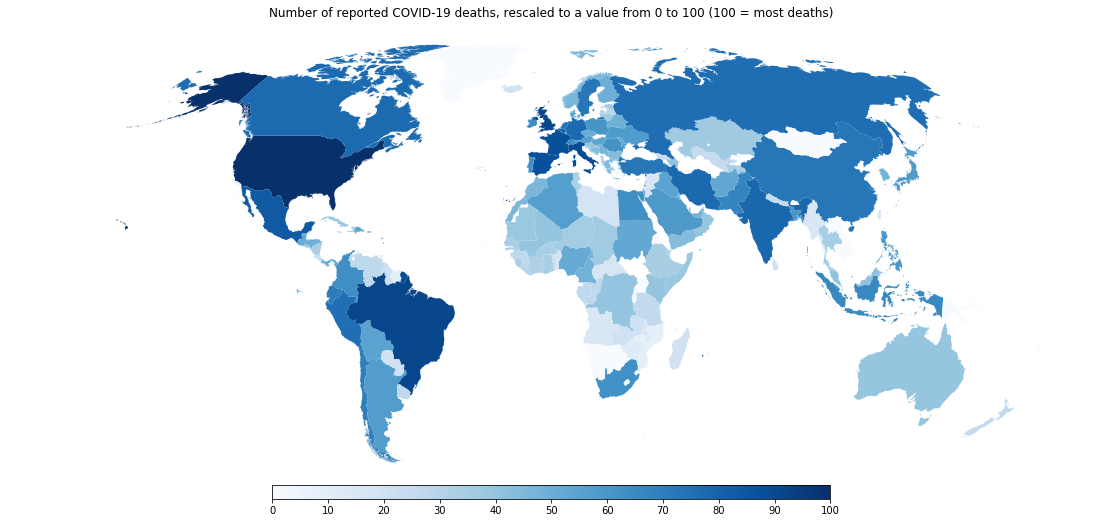

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
merged.dropna().plot(column = 'total_deaths', 
                     ax = ax, 
                     cmap = 'Blues',
                     k = 10, 
                     legend = True, 
                     legend_kwds = {'orientation': "horizontal",
                                  'shrink' : 0.5, 
                                  'pad' : 0, 
                                  'ticks' : np.linspace(0, 100, 11),
                                  'aspect' : 40},
                    )
ax.set_axis_off()
plt.title('Number of reported COVID-19 deaths, rescaled to a value from 0 to 100 (100 = most deaths)')
fig.savefig("total_deaths.png")

At a glance, we can easily tell that the severity of the virus in the US is much greater than in other parts of the world. We can make a similar chloropleth map for total cases. 

In [12]:
cases = responses.merge(data, on = ["CountryName", "Date"])
cases = cases.groupby(["CountryName"]).apply(lambda g : g.iloc[-1, :])[["CountryCode", "total_cases"]].reset_index()
cases.sample(5)

,CountryName,CountryCode,total_cases
161,United States,USA,2094069
160,United Kingdom,GBR,295889
34,China,CHN,84335
56,France,FRA,157220
15,Belize,BLZ,21


In [13]:
merged = gdf.merge(cases, left_on = 'ADM0_A3', right_on = 'CountryCode')
merged['total_cases'] = fun(merged['total_cases'])
merged['total_cases'] = merged['total_cases'] * 100 / np.max(merged['total_cases'])
merged.sample(5)

,ADM0_A3,geometry,CountryName,CountryCode,total_cases
18,FRA,"MULTIPOLYGON (((-5110801.829 226125.278, -5113...",France,FRA,82.210334
12,SOM,"POLYGON ((4380369.737 699282.896, 4382306.327 ...",Somalia,SOM,54.033840
89,HRV,"MULTIPOLYGON (((1385646.023 4962668.460, 13861...",Croatia,HRV,53.038652
58,LAO,"POLYGON ((9436375.870 2395465.743, 9437242.047...",Laos,LAO,20.230271
9,ISR,"POLYGON ((3093872.093 3338162.433, 3095187.213...",Israel,ISR,67.734800


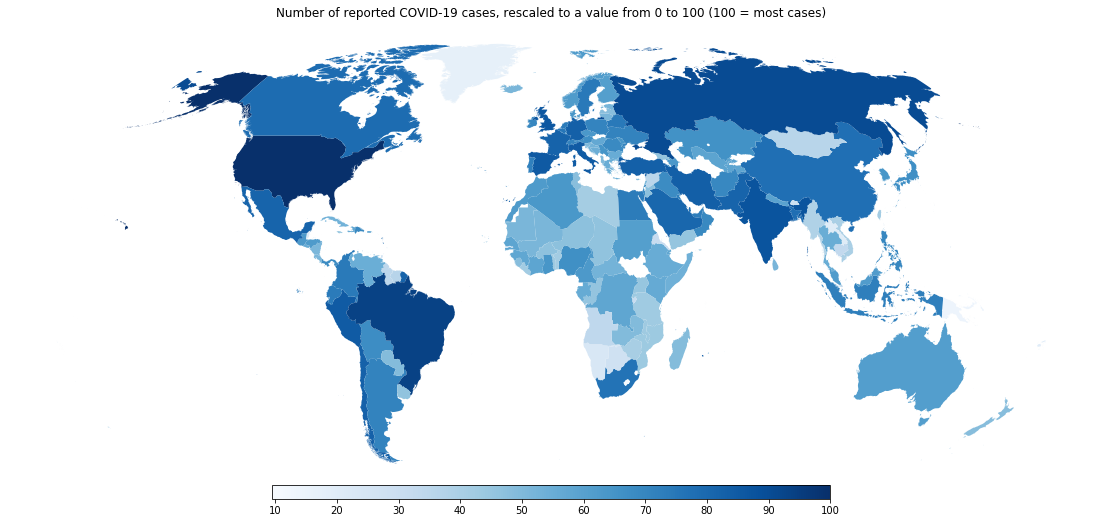

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
merged.dropna().plot(column = 'total_cases', 
                     ax = ax, 
                     cmap = 'Blues',
                     k = 10, 
                     legend = True, 
                     legend_kwds = {'orientation': "horizontal",
                                  'shrink' : 0.5, 
                                  'pad' : 0, 
                                  'ticks' : np.linspace(0, 100, 11),
                                  'aspect' : 40},
                    )
ax.set_axis_off()
plt.title('Number of reported COVID-19 cases, rescaled to a value from 0 to 100 (100 = most cases)')
fig.savefig("total_cases.png")

This map looks strikingly similar to the previous one, probably because the number of deaths per country is proportional to the number of cases per country. It might be more insightful to map the number of new deaths per country.

In [15]:
new_deaths = responses.merge(data, on = ["CountryName", "Date"])
new_deaths = new_deaths.groupby(["CountryName"]).apply(lambda g : g.iloc[-1, :])[["CountryCode", "new_deaths"]].reset_index()
new_deaths.sample(5)

,CountryName,CountryCode,new_deaths
141,South Sudan,SSD,0
7,Australia,AUS,0
44,Denmark,DNK,0
142,Spain,ESP,0
118,Panama,PAN,8


In [16]:
merged = gdf.merge(new_deaths, left_on = 'ADM0_A3', right_on = 'CountryCode')
merged['new_deaths'] = fun(merged['new_deaths'])
merged['new_deaths'] = merged['new_deaths'] * 100 / np.max(merged['new_deaths'])
merged.sample(5)

,ADM0_A3,geometry,CountryName,CountryCode,new_deaths
143,AUS,"MULTIPOLYGON (((11866340.640 -3380326.772, 118...",Australia,AUS,0.000000
118,COL,"MULTIPOLYGON (((-7446457.988 153402.447, -7444...",Colombia,COL,67.284841
46,SWE,"MULTIPOLYGON (((1415990.770 7188840.824, 14198...",Sweden,SWE,0.000000
34,KAZ,"MULTIPOLYGON (((7205476.061 5232097.897, 71941...",Kazakhstan,KAZ,21.604367
134,MEX,"MULTIPOLYGON (((-8909803.944 2777084.668, -891...",Mexico,MEX,87.189416


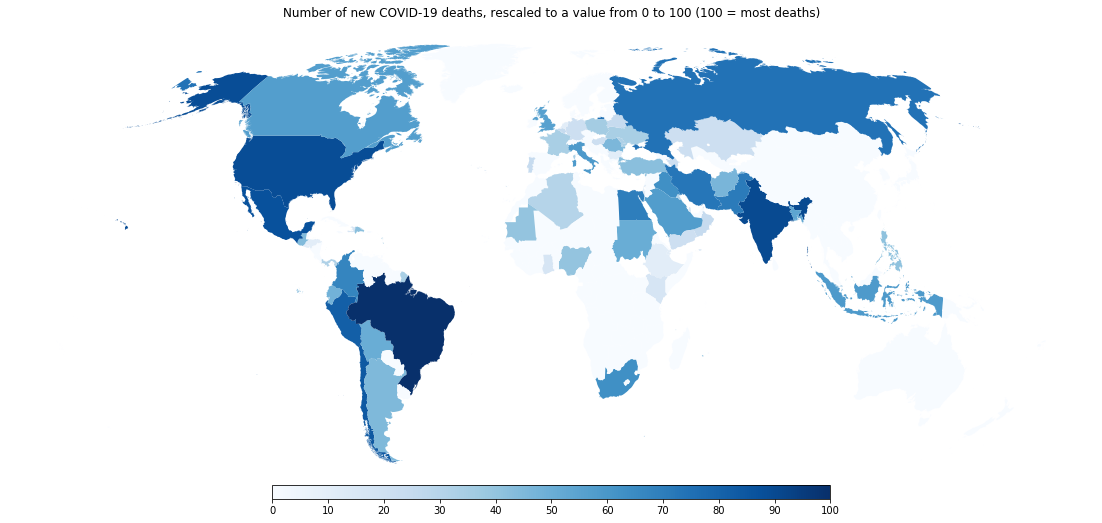

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
merged.dropna().plot(column = 'new_deaths', 
                     ax = ax, 
                     cmap = 'Blues',
                     k = 10, 
                     legend = True, 
                     legend_kwds = {'orientation': "horizontal",
                                  'shrink' : 0.5, 
                                  'pad' : 0, 
                                  'ticks' : np.linspace(0, 100, 11),
                                  'aspect' : 40},
                    )
ax.set_axis_off()
plt.title('Number of new COVID-19 deaths, rescaled to a value from 0 to 100 (100 = most deaths)')
fig.savefig("new_deaths.png")

The deep blue countries are those that are still struggling the most with containing the virus (as of June 15, 2020). We can precisely identify these countries by sorting the <code>new_deaths</code> dataframe.

In [18]:
new_deaths.sort_values(by = 'new_deaths', ascending = False).head(10)

,CountryName,CountryCode,new_deaths
22,Brazil,BRA,612
73,India,IND,325
161,United States,USA,296
101,Mexico,MEX,269
33,Chile,CHL,222
121,Peru,PER,190
128,Russia,RUS,119
75,Iran,IRN,107
116,Pakistan,PAK,97
49,Egypt,EGY,91


Rather than just looking at the latest data, let's see how the pandemic has evolved over time. Let's create an animation showing changes in government policy over time. The University of Oxford has aggregated government responses into a single statistic called the stringency index, which roughly measures the strength of a country's response to the virus. Let's isolate this data into a single dataframe and use it to plot choropleth maps for each day starting in January.

In [19]:
si = responses[["Date", "CountryCode", "StringencyIndex"]]
cmap_blue = plt.cm.get_cmap('Blues', 10)
cmap_grey = colors.ListedColormap(['gray'])

In [20]:
dates = responses['Date'].sort_values().unique()
for i, date in enumerate(dates):
    fig, ax = plt.subplots(1, 1, figsize = (20, 10))
    si_i = si[si["Date"] == date]
    merged = gdf.merge(si_i, left_on = 'ADM0_A3', right_on = 'CountryCode')
    merged["StringencyIndex"] = merged["StringencyIndex"] * 100 / np.max(merged["StringencyIndex"])
    merged.dropna().plot(column = 'StringencyIndex', ax = ax, cmap = cmap_blue, edgecolor = "black")
    temp = merged.isna().any(axis = 1)
    if np.sum(temp) > 0:
        merged[merged.isna().any(axis = 1)].plot(ax = ax, color = 'gray', edgecolor = "black")
    ax.set_axis_off()
    ax.set_title('Government stringency index, rescaled to a value from 0 to 100 (100 = strictest)\n' + str(date)[:10])
    ax2 = fig.add_axes([0.3, 0, 0.5, 0.02])
    ax3 = fig.add_axes([0.2, 0, 0.05, 0.02])
    cbar1 = fig.colorbar(plt.cm.ScalarMappable(norm = colors.Normalize(vmin = 0, vmax = 100), cmap = cmap_blue),
                         cax = ax2, orientation = 'horizontal', ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    cbar2 = fig.colorbar(plt.cm.ScalarMappable(norm = colors.Normalize(vmin = 0, vmax = 0), cmap = cmap_grey),
                         cax = ax3, orientation = 'horizontal', label = "No data")
    cbar2.set_ticks([])
    fig.savefig("./stringency_maps/si_" + str(i) + ".png", bbox_inches = "tight")
    plt.close(fig)

Now that we've generated all the chropleth maps, we can create a gif.

In [21]:
frames = []
for i in range(0, len(dates)):
    new_frame = Image.open("./stringency_maps/si_" + str(i) + ".png")
    frames.append(new_frame)
frames[0].save('stringency_gif.gif', format = 'GIF',
               append_images = frames[1:],
               save_all = True,
               duration = 300, 
               loop = 0)

The Americas appear to react slower than other continents, which could explain their high infection rates. It will be interesting to track policy changes over the next few months, to see which governments are willing to keep sacrificing economic well-being in favor of public health. 

As a final exercise, let's animate the total death rate of COVID-19.

In [69]:
df = responses.merge(data, on = ["CountryName", "Date"])[["CountryCode", "Date", "total_deaths"]]
dates = df["Date"].sort_values().unique()
for i, date in enumerate(dates):
    fig, ax = plt.subplots(1, 1, figsize = (20, 10))
    df_i = df[df["Date"] == date]
    merged = gdf.merge(df_i, left_on = 'ADM0_A3', right_on = 'CountryCode', how = "outer")
    merged["total_deaths"] = fun(merged["total_deaths"])
    max_deaths = np.max(merged["total_deaths"])
    if max_deaths > 0:
        merged["total_deaths"] = merged["total_deaths"] * 100 / np.max(merged["total_deaths"])
    merged.dropna().plot(column = "total_deaths", ax = ax, cmap = cmap_blue, edgecolor = "black")
    temp = merged.isna().any(axis = 1)
    if np.sum(temp) > 0:
        merged[merged.isna().any(axis = 1)].plot(ax = ax, color = 'gray', edgecolor = "black")
    ax.set_axis_off()
    ax.set_title('Total COVID-19 deaths, rescaled to a value from 0 to 100 (100 = most deaths)\n' + str(date)[:10])
    ax2 = fig.add_axes([0.3, 0, 0.5, 0.02])
    ax3 = fig.add_axes([0.2, 0, 0.05, 0.02])
    cbar1 = fig.colorbar(plt.cm.ScalarMappable(norm = colors.Normalize(vmin = 0, vmax = 100), cmap = cmap_blue),
                         cax = ax2, orientation = 'horizontal', ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    cbar2 = fig.colorbar(plt.cm.ScalarMappable(norm = colors.Normalize(vmin = 0, vmax = 0), cmap = cmap_grey),
                         cax = ax3, orientation = 'horizontal', label = "No data")
    cbar2.set_ticks([])
    fig.savefig("./deaths_maps/df_" + str(i) + ".png", bbox_inches = "tight")
    plt.close(fig)

As before, we combine the generated images into a gif.

In [70]:
frames = []
for i in range(0, len(dates)):
    new_frame = Image.open("./deaths_maps/df_" + str(i) + ".png")
    frames.append(new_frame)
frames[0].save('deaths_gif.gif', format = 'GIF',
               append_images = frames[1:],
               save_all = True,
               duration = 300, 
               loop = 0)